# Variational Inference Implementation

# Imports

In [11]:
import os
import numpy as np
import pandas as pd

from scipy.stats import norm, gamma
from scipy.stats import multivariate_normal as m_norm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.special import gamma as gamma_function

plt.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
sns.set_palette('deep')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Assignment 2 - Variational Inference

In [15]:
# READING DATA
data = np.genfromtxt('../data/gaussian_1d.csv', delimiter=',')
print('Shape:', data.shape)
data = data.reshape(-1, 1)
data[:5, :]

Shape: (500,)


array([[1.23234324],
       [2.70522973],
       [2.20009601],
       [0.93488879],
       [1.59086784]])

In [16]:
def ELBO(k, a, b):
    return 0.5*np.log(1/k) + np.log(gamma_function(a)) - a*np.log(b)


>>> Sample Size: 10


EXPECTED MU: 1.6635318570534805
EXPECTED TAU: 1.739539118133071 



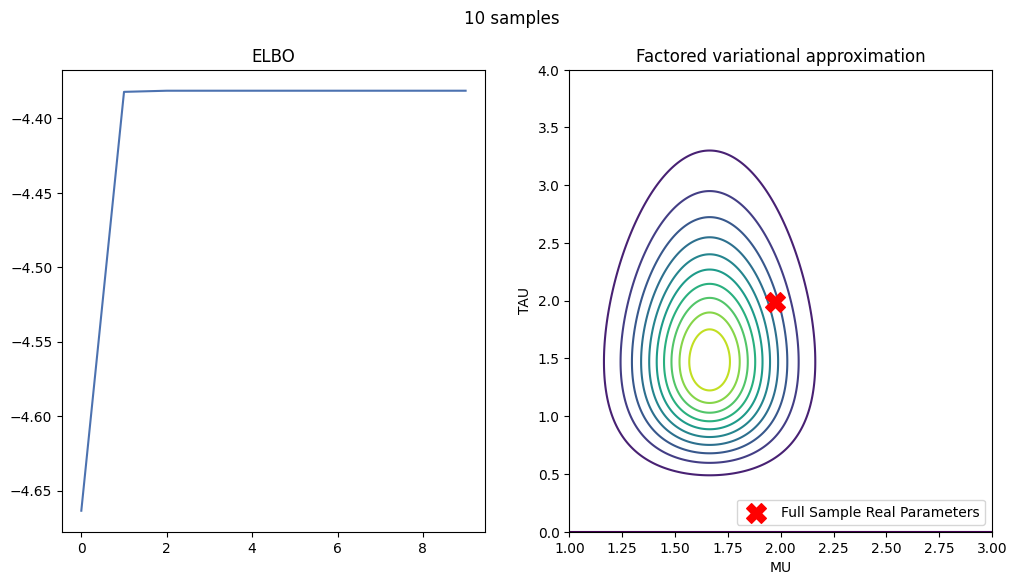


>>> Sample Size: 50


EXPECTED MU: 2.021525461665468
EXPECTED TAU: 1.8327722600015466 



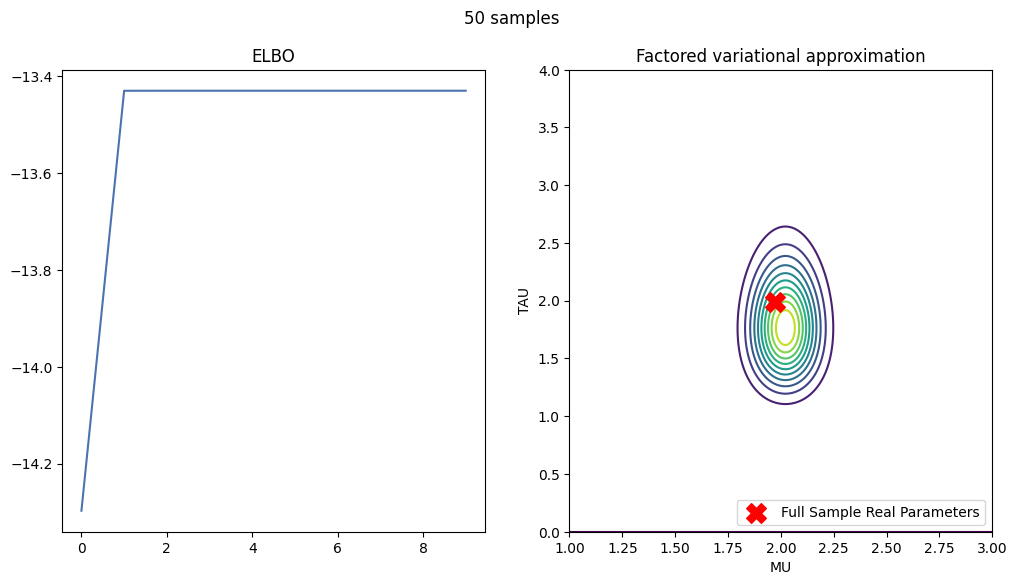


>>> Sample Size: 100


EXPECTED MU: 1.8866458035690432
EXPECTED TAU: 2.075508907540726 



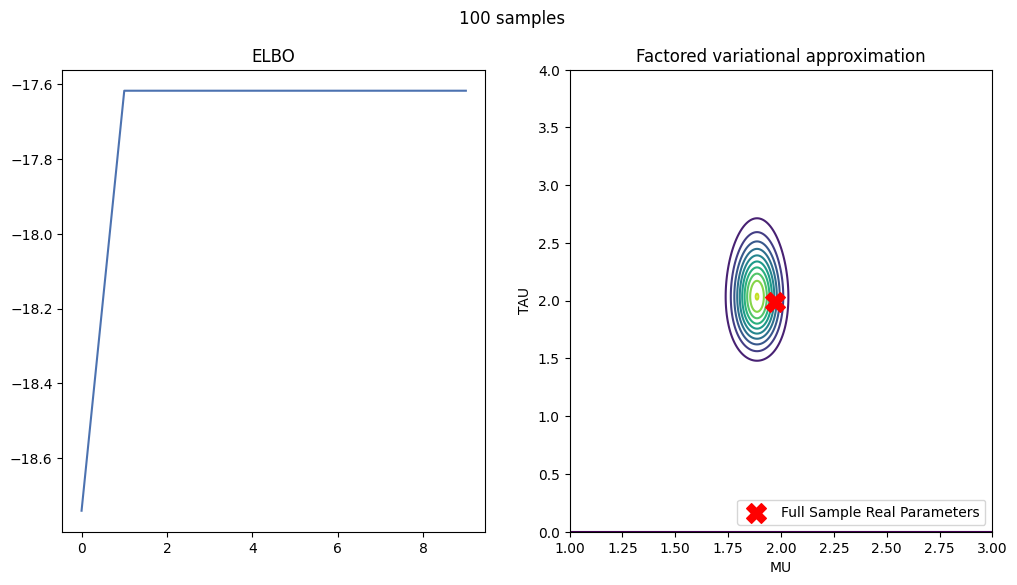


>>> Sample Size: 500


EXPECTED MU: 1.9687371100567022
EXPECTED TAU: 1.9496079147975363 



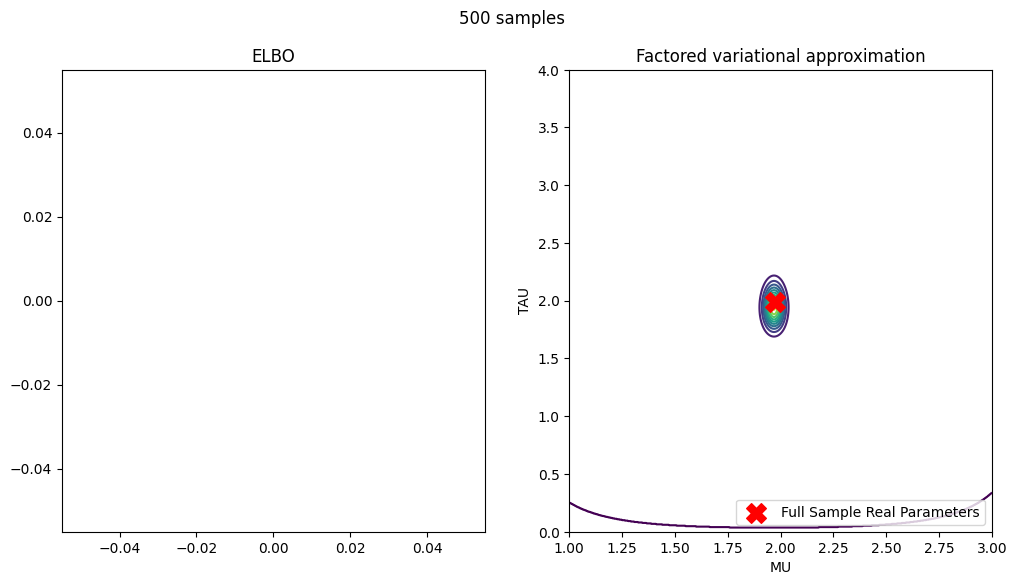

In [17]:
rng = np.random.default_rng(64852)

full_data_mu = data.mean()
full_data_tau = 1 / (data.std()**2)

for n_samples in [10, 50, 100, 500]:
    print(f'\n>>> Sample Size: {n_samples}\n')

    # Making choice of samples
    indexes = rng.choice(data.shape[0], size=n_samples, replace=False)
    X = data[indexes, :]

    # Sample size
    N = X.shape[0]

    # Initializing priori parameters
    mu_0 = 0
    k_0 = 1
    a_0 = 1
    b_0 = 1

    # Optimal values for mu_n and a_n
    mu_n = (k_0 * mu_0 + X.sum()) / (k_0 + N)
    a_n = a_0 + ((N + 1) / 2)
    
    # Initializing b_n and k_n
    b_n = 1
    k_n = 1

    # Iteration
    arr_elbo = []
    for i in range(10):
        k_n = (k_0 + N) * (a_n / b_n)
        first_term =  b_0 + (k_0 / 2) * (1/k_n + (mu_n - mu_0)**2)
        second_term = np.sum((1/k_n) + (X - mu_n)**2) / 2
        b_n = first_term + second_term

        arr_elbo.append(ELBO(k_n, a_n, b_n))

    # Defining posteriori distributions
    # The scipy's scale parameter is 1/b
    tau_dist = gamma(a=a_n, scale=1/b_n) # scale parameter is 1/b
    # The scipy's scale parameter is the standard deviation
    mu_dist = norm(loc=mu_n, scale=1/np.sqrt(k_n)) 
    
    # Show results
    dim = 1000
    mu_list = np.linspace(1, 3, dim)
    tau_list = np.linspace(0, 4, dim)

    mu_list, tau_list = np.meshgrid(mu_list, tau_list)
    mu_list, tau_list = mu_list.flatten(), tau_list.flatten()

    # Factored variational approximation
    Z = mu_dist.pdf(mu_list) * tau_dist.pdf(tau_list)

    mu_list = mu_list.reshape(dim, dim)
    tau_list = tau_list.reshape(dim, dim)
    Z = Z.reshape(dim, dim)
    
    print('\nEXPECTED MU:', mu_dist.mean())
    print('EXPECTED TAU:', tau_dist.mean(), '\n')

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].set_title('ELBO')
    ax[0].plot(arr_elbo)

    ax[1].set_title(f'Factored variational approximation')
    ax[1].contour(mu_list, tau_list, Z, levels=10)
    ax[1].scatter(
        full_data_mu, full_data_tau, s=200, c='r', marker='X',
        label='Full Sample Real Parameters',
        zorder=100
    )
    
    ax[1].set_xlabel('MU')
    ax[1].set_ylabel('TAU')
    ax[1].legend(loc='lower right')

    plt.suptitle(f'{n_samples} samples')
    plt.show()
